# Observed Values

In [ ]:
%matplotlib inline

Select option 1 to use UDP data with 10s simulation time
Select option 2 to use UDP data with 20s simulation time
Select option 3 to use UDP data with 100s simulation time
Select option 4 to use UDP data with 200s simulation time
Select option 5 to use UDP data with 1000s simulation time
Select option 6 to use UDP data with 2000s simulation time
Select option 7 to use UDP data with 10000s simulation time
Select option 8 to use UDP data with 20000s simulation time

Choose an option from the list: 6

Enter a time step size to extract incoming packet arrival rate (packets per time unit) for data: 0.2

         Time  Packets Received
0        0.0               0.0
1        0.2              16.0
2        0.4              20.0
3        0.6              25.0
4        0.8              18.0
...      ...               ...
9995  1999.0              17.0
9996  1999.2              23.0
9997  1999.4              24.0
9998  1999.6              25.0
9999  1999.8              17.0

[10000 rows x 2 colu

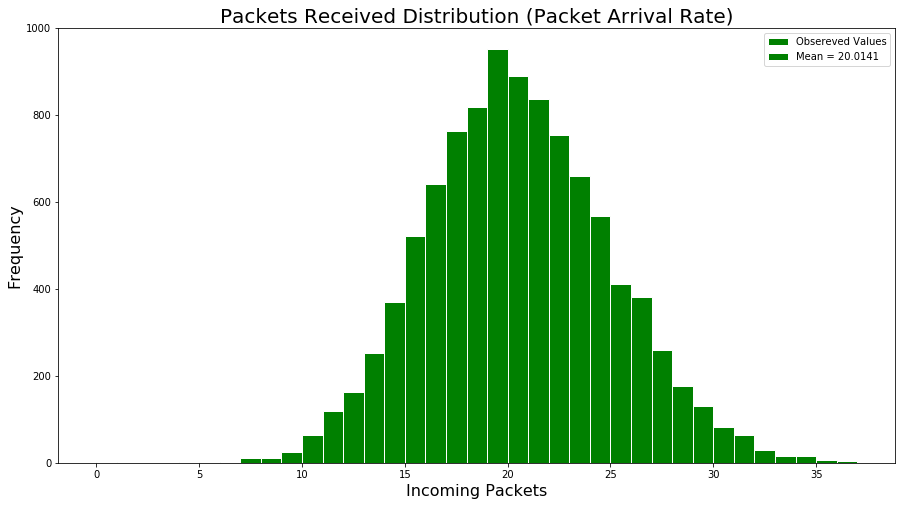

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
from decimal import Decimal
import math
import time

udp_data = {
    1:'10s',
    2:'20s',
    3:'100s',
    4:'200s',
    5:'1000s',
    6:'2000s',
    7:'10000s',
    8:'20000s'
    }

for key, value in udp_data.items():
    print(f"Select option {key} to use UDP data with {value} simulation time")
    
user_input = True
while user_input:
    try:
        select = int(input("\nChoose an option from the list: "))
        if select not in udp_data.keys():
            raise KeyError
    except KeyError:
         print("Oops!  That was not a  valid key.  Try again...")
    except:
        print("Please enter a valid integer value!")
    else:
        user_input = False

# Data is read from the CSV file and saved to a container 
cols = ['Time', 'PacketReceived']
data = pd.read_csv(f'udp_rcvd_vector_{udp_data[select]}.csv', delimiter=',', skiprows=[0], names=cols)
#X = data['Time']
df = pd.DataFrame(data)

time_unit_step = float(input("\nEnter a time step size to extract incoming packet arrival rate (packets per time unit) for data: "))

# Time is divided into interval and corresponding data points are also arranged accordingly   
max_time = float(math.ceil(df['Time'].max()))
min_time = float(math.floor(df['Time'].min()))

df_summary = df["PacketReceived"].groupby(pd.cut(df["Time"], 
            np.arange(min_time, max_time + time_unit_step, time_unit_step), labels=np.arange(int(min_time),int(max_time), 
            Decimal(f'{time_unit_step}')))).count().to_frame('Packets Received').reset_index()

df2_summary = df_summary.astype(float)

# Genenerated vectors from the previous setp are written to a seperate CSV file 
with open(f'packet_data_{udp_data[select]}_temp.csv', 'w') as csv_file:
    df2_summary.to_csv(path_or_buf=csv_file)

time.sleep(1)

# Newly generated data is read in the following block of code for further processing and plotting 
columns = ['Time', 'Packets Received']
df = pd.read_csv(f'packet_data_{udp_data[select]}_temp.csv',delimiter=',', skiprows=[0], names=columns)

print("\n", df, "\n")
x = df['Time']
y = df['Packets Received']

plt.figure(figsize=(15,8))
plt.title('Packets Received Distribution (Packet Arrival Rate)', size = 20)
plt.xlabel('Incoming Packets', size = 16)
plt.ylabel('Frequency', size = 16)
plt.hist(y, bins = range(int(y.min()), int(y.max())+1, 1) , color = 'green', ec = 'white', label = True)
plt.legend(['Obsereved Values',f"Mean = {y.mean()}"], loc='upper right')


print(f"Minimum packet rate value: {y.min()}")
print(f"Maximum packet rate value: {y.max()}")


# Expected Values

In [2]:
from numpy import savetxt
from scipy.stats import poisson

np.set_printoptions(suppress=True)

def interval_range():
    interval_range = []
    interval_range.append(obs_min)
    value = obs_min
    for i in range(1, int(k)+1, 1):
        if (value <= obs_max):
            value += interval_size
            interval_range.append(value)
    return interval_range

def np_j_less_than_5(array):
    counter = 0
    for i in array:
        if i < 5.0:
            counter+=1
    return counter

# We are required to generate an expected array with the same mean as the observed array

columns = ['Time', 'Packet_Rate Interval']
df = pd.read_csv(f'packet_data_{udp_data[select]}_temp.csv',delimiter=',', skiprows=[0], names=columns)
y =  df['Packet_Rate Interval']

run = True
while run:
    try:
        k = float(input("\nEnter the number of intervals desired for Chi-Square Test: ")) #Interval
        
        obs_max = y.max()
        obs_min = y.min()
        interval_size = (obs_max - obs_min) / k

        equi_distant_table = df["Packet_Rate Interval"].groupby(pd.cut(df["Packet_Rate Interval"], 
           interval_range(), include_lowest=True)).count().to_frame('N_j').reset_index()

        n_pts = equi_distant_table['N_j'].sum() # number of data points (sum of occurrances)

        # Observed occurances of data is saved to csv file
        savetxt(f'observed_{udp_data[select]}_temp.csv', equi_distant_table['N_j'], delimiter=',')

        # Here we calculate the pdf for each bin and multiply it by the total count to get expected frequency array
        expected_frequency = []
        for i in range(1, int(k) + 1, 1):
            expected_frequency.append(n_pts * (poisson.cdf(obs_min + i * interval_size, y.mean()) - 
                                               poisson.cdf(obs_min + (i-1) * interval_size, y.mean())))
        
        if (k >= 3 and (min(expected_frequency) >= (5 * np_j_less_than_5(expected_frequency))/int(k))):
            equi_distant_table['np_j'] = np.array(expected_frequency)
            equi_distant_table['(N_j - np_j)^2/np_j'] = ((equi_distant_table['N_j'] - 
                                                          equi_distant_table['np_j'])**2)/equi_distant_table['np_j']

            print("\n", equi_distant_table)

            # Expected frequency of data is saved to csv file
            savetxt(f'expected_{udp_data[select]}_temp.csv', equi_distant_table['np_j'], delimiter=',')
        else:
            raise Exception
            
    except:
        if (k < 3):
            print(f"\nConsider entering a new interval that is at least 3 !!!")
        else:
            print(f"\nConsider entering a new interval that is less than {int(k)} !!!")
        continue 
        
    else:
        run = False


Enter the number of intervals desired for Chi-Square Test: 20

    Packet_Rate Interval   N_j         np_j  (N_j - np_j)^2/np_j
0       (58.999, 63.25]     1     0.882092             0.015761
1         (63.25, 67.5]     3     5.072963             0.847074
2         (67.5, 71.75]    12    23.021661             5.276640
3         (71.75, 76.0]   141   123.997783             2.331295
4         (76.0, 80.25]   329   310.901891             1.053521
5         (80.25, 84.5]   686   710.652583             0.855200
6         (84.5, 88.75]  1385  1343.924406             1.255431
7         (88.75, 93.0]  2795  2768.513405             0.253399
8         (93.0, 97.25]  2948  2941.758386             0.013243
9        (97.25, 101.5]  3055  3174.507729             4.498996
10      (101.5, 105.75]  2930  2924.808636             0.009214
11      (105.75, 110.0]  2747  2777.984770             0.345594
12      (110.0, 114.25]  1460  1406.376671             2.044588
13      (114.25, 118.5]   811   805.902

# Chi-Square Test

In [3]:
from scipy.stats import chisquare
from scipy import stats

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

dof = k - 1
crit = stats.chi2.ppf(q=0.95, df=dof) # q here is 1 - alpha, which is 0.05
print(f"Chi-Square Critical Value is {crit}\n---\n")

cols = ['obs']
obs = pd.read_csv(f'observed_{udp_data[select]}_temp.csv',delimiter=',', names = cols)
observed_vals = obs['obs']

cols1 = ['exp']
exp = pd.read_csv(f'expected_{udp_data[select]}_temp.csv',delimiter=',', names=cols1)
expected_vals = exp['exp']

chisq_sum = equi_distant_table['(N_j - np_j)^2/np_j'].sum()
print(f"Measured Chi-Square Value is {chisq_sum}")

chisq, p = chisquare(observed_vals, f_exp = expected_vals, ddof = 0, axis = 0)
print(f"Chi-Square Value using built-in function is {chisq}")
print(f"P-Value using built-in function is {p}")

if (chisq < crit): print("\nThe null hypothesis, H0, is ACCEPTED!".translate(SUB))
else: print("\nThe null hypothesis, H0, is REJECTED!".translate(SUB))


Chi-Square Critical Value is 30.14352720564616
---

Measured Chi-Square Value is 24.8577051443198
Chi-Square Value using built-in function is 24.857705144319816
P-Value using built-in function is 0.1652795487131846

The null hypothesis, H₀, is ACCEPTED!
